# A First Neural Network Example

In this demo, you will learn:
* How to construct and train a simple neural network with one hidden layer using the `keras` package
* How to get the weights and intermediate layer outputs of a `keras` network after training
* How to visualize the weights

To illustrate the concepts, we consider a simple 2D classification problem on completely synthetic data. Using synthetic data will allow us to visualize the network more easily.  We will then look at real data in later demos  

## Loading Tensorflow and Keras

Before starting this demo, you will need to install [Pytorch](https://pytorch.org/get-started/locally/).  If you are using [Google colaboratory](https://colab.research.google.com), Pytorch is already installed.


First we check that tensorflow is installed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# prompt: Convert the code above to pytorch




# Create an instance of the network
net = Net(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Example loss function for classification
optimizer = optim.SGD(net.parameters(), lr=0.01) # Example optimizer


# Example synthetic data (replace with your actual data)
inputs = torch.randn(100, input_size)
labels = torch.randint(0, output_size, (100,))


# Training loop (replace with your training loop)
for epoch in range(10):  # Example number of epochs
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

# Access weights and intermediate layer outputs
# Example: access weights of the first layer
weights_fc1 = net.fc1.weight.data
print(weights_fc1)

# Example: access the output of the hidden layer
intermediate_output = net.fc1(inputs)
intermediate_output



We also load some other common packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Synthetic Data

To illustrate the neural network we generate data with some rule that will create an interesting classification region.

In [15]:
nsamp = 400   # number of samples to generate
nx = 2        # number of dimensions of each sample

# The features are generated uniformly on the square [0,1] x [0,1]
X = np.random.uniform(0,1,(nsamp,nx))

# The class of each sample is determined by some Gaussian.  The particular function is not important.
rsq = (X[:,0]-0.5)**2 + (X[:,1]-0.5)**2
z = 10*(np.exp(-8*rsq)-0.5)
py = 1/(1+np.exp(-z))
u = np.random.uniform(0,1,nsamp)
y = (u < py).astype(int)

We create a scatter plot of the data.  You can see that it is not linearly seperable.  

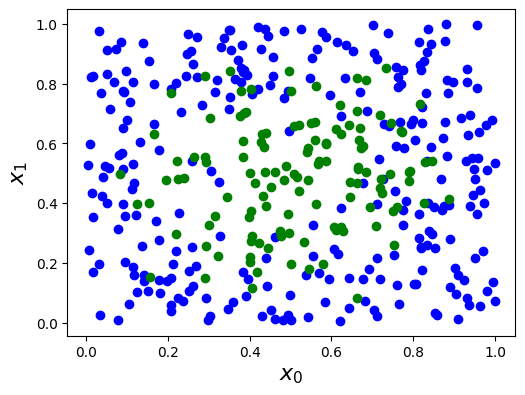

In [16]:
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')
plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
plt.subplots_adjust(bottom=0.2, left=0.2)

## Creating a Simple Neural Network.

We see that the above points are not linearly separable.  We will see if we can build a simple neural network classifier to find a good decision region.

Neural networks in PyTorch are represented as `class` derived from the `nn.Module`.  In the constructor of the class, we define the layers of the neural network.  In this case, there are four layers:
*  A fully connected linear layer (FC1)
*  An activation layer with sigmoids (activation)
*  A second fully connected layer (FC2)
*  A sigmoid output since we are performing binary classification
The dimensions are passed in the contructor.

The `forward()` method then take the input through the steps in the neural network to create the output.

In [48]:

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


We next create an instance of the neural network for our problem.  Note that there is a single output since we are performing binary classification.


In [49]:
nin = nx  # Number of inputs
nh = 4   # Number of hidden units

model = Net(nin, nh)

# Print a summary
print(model)

Net(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (activation): Sigmoid()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


We can also print the number of parameters per layer

In [50]:
# Iterate through the model's layers and print parameter counts
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

fc1.weight 8
fc1.bias 4
fc2.weight 4
fc2.bias 1


## Training the Network

To train the network, we have to select an optimizer and a loss function.  Since this is a binary classification problem, we select the `binary_crossentropy` loss.  For the optimizer, `adam` tends to works well over a wide range of problems and is a good starting point.  We also set the `metrics` that we wish to track during the optimization.  In this case, we select `accuracy` on the training set.

In [51]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Example optimizer

Next, we have to convert the `numpy` arrays `X,y` to `torch` tensors and load them into a `DataLoader` class that can provide mini-batches of data.  

In [52]:
from torch.utils.data import DataLoader, TensorDataset

# Convert your data to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Reshape y to be (n_samples, 1)

# Create a TensorDataset
dataset = TensorDataset(X_torch, y_torch)

# Create a DataLoader
batch_size = 100
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Now we will run the data over many epochs to train.


In [54]:
# prompt: Fit the data with the optimizer above on the data `X` and `y` with a batch size of 100 and 1000 epochs.  Shuffle the data in the mini-batch and print the training accuracy and loss every 100 epochs.  Use a DataLoader class to create the mini-batches.

lossval = []
epochval = []
accval = []

# Training loop with DataLoader
num_epochs = 1000
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        # Calculate training accuracy
        with torch.no_grad():
            outputs = model(X_torch)
            predicted = (outputs > 0.5).float()
            accuracy = (predicted == y_torch).sum().item() / len(y)

        # Save the values
        lossval.append(loss.item())
        epochval.append(epoch)
        accval.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch [20/1000], Loss: 0.6741, Accuracy: 0.6875
Epoch [40/1000], Loss: 0.5348, Accuracy: 0.6875
Epoch [60/1000], Loss: 0.5951, Accuracy: 0.6875
Epoch [80/1000], Loss: 0.6354, Accuracy: 0.6875
Epoch [100/1000], Loss: 0.6107, Accuracy: 0.6875
Epoch [120/1000], Loss: 0.6742, Accuracy: 0.6875
Epoch [140/1000], Loss: 0.6744, Accuracy: 0.6875
Epoch [160/1000], Loss: 0.5656, Accuracy: 0.6875
Epoch [180/1000], Loss: 0.5880, Accuracy: 0.6875
Epoch [200/1000], Loss: 0.6113, Accuracy: 0.6875
Epoch [220/1000], Loss: 0.6583, Accuracy: 0.6875
Epoch [240/1000], Loss: 0.6428, Accuracy: 0.6875
Epoch [260/1000], Loss: 0.5871, Accuracy: 0.6875
Epoch [280/1000], Loss: 0.6188, Accuracy: 0.6875
Epoch [300/1000], Loss: 0.6420, Accuracy: 0.6875
Epoch [320/1000], Loss: 0.6255, Accuracy: 0.6875
Epoch [340/1000], Loss: 0.6297, Accuracy: 0.6875
Epoch [360/1000], Loss: 0.6027, Accuracy: 0.6875
Epoch [380/1000], Loss: 0.5758, Accuracy: 0.6875
Epoch [400/1000], Loss: 0.5953, Accuracy: 0.6875
Epoch [420/1000], Loss: 

Unfortunately, for this problem, we need a large number of epochs -- around 1000.  We don't want to print out the progress on each epoch.  So, the code below disables the print outs by setting `verbose=0`.  Then, we run the optimization in 20 iterations with 50 epochs per iteration -- a total of 1000 epochs.  In each iteration, we use the `evaluate` method to get the loss function and accuracy and print that out manually.

We can now plot the loss function and accuracy as a function of the epoch number.  

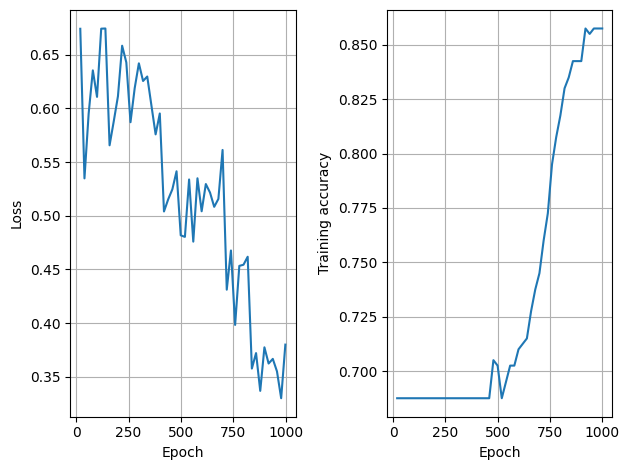

In [55]:
epochval = np.array(epochval)
lossval = np.array(lossval)
accval = np.array(accval)

plt.subplot(1,2,1)
plt.plot(epochval, lossval)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochval, accval)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.tight_layout()
plt.show()

## Visualizing Decision Regions

To see how classification rule our neural network learned, we can plot the predicted class probability as a function of `(x_0,x_1)`.  To do this, we create an input matrix `Xplot` with entries that vary over `[0,1] \times [0,1]`.  We feed that into the trained network and see what the probility `P(y=1|x)` is for each sample.  Then, we plot this like an image.

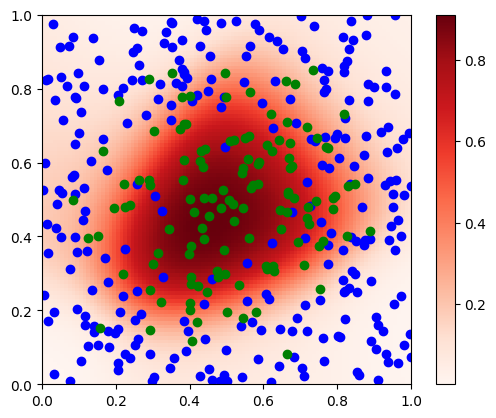

In [56]:
# Limits to plot the response.
xmin = [0,0]
xmax = [1,1]

# Use meshgrid to create the 2D input
nplot = 100
x0plot = np.linspace(xmin[0],xmax[1],nplot)
x1plot = np.linspace(xmin[0],xmax[1],nplot)
x0mat, x1mat = np.meshgrid(x0plot,x1plot)
Xplot = np.column_stack([x0mat.ravel(), x1mat.ravel()])

# Compute the output
with torch.no_grad():
    yplot = model(torch.tensor(Xplot, dtype=torch.float32))

# Convert yplot to numpy
yplot = yplot.numpy()
yplot_mat = yplot[:,0].reshape((nplot, nplot))

# Plot the recovered region
plt.imshow(np.flipud(yplot_mat), extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
plt.colorbar()

# Overlay the samples
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')

We see that the neural network is able to learn a nonlinear classification region matching the training data points.  To understand how this nonlinear region is realized it is useful to plot the response in the each of the hidden units.  To extract the output of an intermediate layer, we create a new model, `model_act` with the outputs set to the activation outputs in the original model and then run the `predict` command on that model.

In [60]:

b2 = model.fc2.bias.data.numpy()
print(w2)

[[ 5.793046  -7.3178473  1.2586372 -7.6920195]]


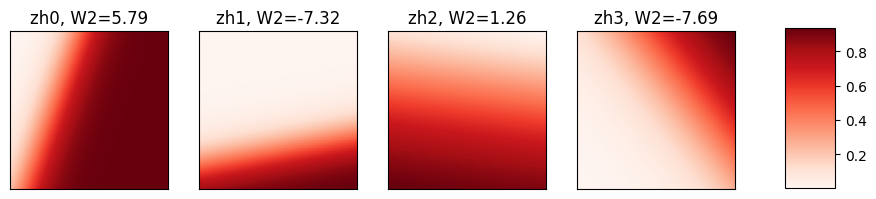

In [63]:
# prompt: Create a new model, model1, with the layers `activation` as the output.

# Assuming 'model' is your trained network
class ModelAct(nn.Module):
    def __init__(self, original_model):
        super(ModelAct, self).__init__()
        self.fc1 = original_model.fc1
        self.activation = original_model.activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        return x

model_act = ModelAct(model)

# Compute the output
with torch.no_grad():
    zhid_plot = model_act(torch.tensor(Xplot, dtype=torch.float32))
zhid_plot = zhid_plot.numpy()
zhid_plot = zhid_plot.reshape((nplot, nplot,nh))

# Get the weights
w2 = model.fc2.weight.data.numpy()

fig = plt.figure(figsize=(10, 4))

for i in range(nh):

    plt.subplot(1,nh,i+1)
    zhid_ploti = np.flipud(zhid_plot[:,:,i])
    im = plt.imshow(zhid_ploti, extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
    plt.xticks([])
    plt.yticks([])
    plt.title('zh{0:d}, W2={1:4.2f}'.format(i,w2[0,i]))

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.30, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax)

Each of the hidden units produces one linear decision region.  The final nonlinear region is then formed by taking a weighted combination of these regions.

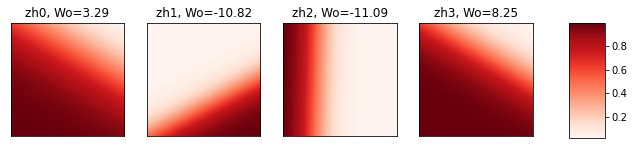

In [ ]:

# Get the response in the hidden units
layer_hid = model.get_layer('hidden')
model1 = Model(inputs=model.input,
               outputs=layer_hid.output)


zhid_plot = model_act.predict(Xplot)
zhid_plot = zhid_plot.reshape((nplot,nplot,nh))

# Get the weights in the output layer
layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()

fig = plt.figure(figsize=(10, 4))

for i in range(nh):

    plt.subplot(1,nh,i+1)
    zhid_ploti = np.flipud(zhid_plot[:,:,i])
    im = plt.imshow(zhid_ploti, extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
    plt.xticks([])
    plt.yticks([])
    plt.title('zh{0:d}, Wo={1:4.2f}'.format(i,Wo[i,0]))

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.30, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax)

## Let us print the model parameters.

First we print the entire model weights

In [ ]:
g=model.get_weights()
print('Model weights')
print(g)

Model weights
[array([[  6.59272   ,  11.723463  ,   0.13931467,   2.011473  ],
       [  3.388066  ,  -5.8400793 , -12.651688  ,  -5.9218583 ]],
      dtype=float32), array([-6.8954244, -0.3916084,  3.3514736,  3.6494682], dtype=float32), array([[-10.406469 ],
       [  7.7749357],
       [ -9.563922 ],
       [  2.2439706]], dtype=float32), array([-3.302257], dtype=float32)]


Now we print individual layer weights

In [ ]:
layer_hid = model.get_layer('hidden')
Wh, bh = layer_hid.get_weights()
print('Wh=')
print(Wh)
print('bh=')
print(bh)

layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()
print('Wo=')
print(Wo)
print('bo=')
print(bo)


Wh=
[[  6.59272     11.723463     0.13931467   2.011473  ]
 [  3.388066    -5.8400793  -12.651688    -5.9218583 ]]
bh=
[-6.8954244 -0.3916084  3.3514736  3.6494682]
Wo=
[[-10.406469 ]
 [  7.7749357]
 [ -9.563922 ]
 [  2.2439706]]
bo=
[-3.302257]


## Computing Gradients via Backpropagation

The tensorflow package computes all the gradients manually.  But, we show how to compute the gradients manually via back-propagation manually so you understand the mathematics.  First, we create a function that evaluates the forward pass of the neural network.  That is, it takes the inputs `X` and parameters `param` to output the loss function.

In [ ]:
def forward(param, X, y):
    """
    Computes the BCE loss for a neural network
    with one hidden layer and sigmoid activations
    """

    # Unpack the parameters
    Wh, bh, Wo, bo = param

    # Hidden layer
    Zh = X.dot(Wh) + bh[None, :]
    Uh = 1/(1+np.exp(-Zh))

    # Output layer
    zo = Uh.dot(Wo) + bo[None, :]
    zo = zo.ravel()

    # Binary cross entropy
    loss = np.sum(np.log(1+np.exp(zo))-y*zo)

    return zo, loss


We will test with some initial values.

In [ ]:
# Random initial values
Wh = np.random.normal(0,1,(nx,nh))
bh = np.random.normal(0,1,(nh,))
Wo = np.random.normal(0,1,(nh,nout))
bo = np.random.normal(0,1,(nout))
param0 = [Wh,bh,Wo,bo]

# Compute output on the training data
zo, loss = forward(param0, X, y)

## In-Class Exercise

Complete the following function that computes the loss and gradients for all the four parameters.  I have already written the gradient and loss for the output layers.  Note the use of broadcasting.  You will need to compute the gradients for the hidden layers.

In [ ]:
def loss_eval(param, X, y):
    """
    Evaluates the loss function and gradients
    for the neural network
    """

    # Unpack the parameters
    Wh, bh, Wo, bo = param

    # Hidden layer
    Zh = X.dot(Wh) + bh[None, :]
    Uh = 1/(1+np.exp(-Zh))

    # Output layer
    zo = Uh.dot(Wo) + bo[None,:]
    zo = zo.ravel()

    # Binary cross entropy
    loss = np.sum(np.log(1+np.exp(zo))-y*zo)

    # Gradient for the output layer.
    # Note the use of broadcasting
    grad_dzo = 1/(1+np.exp(-zo))-y
    grad_Wo = np.sum(Uh[:,:,None]*grad_dzo[:,None,None], axis=0)
    grad_bo = np.sum(grad_dzo)

    # TODO:  Compute gradients for the hidden layer
    # grad_Wh = ...
    # grad_bh = ...
    grad_Wh = 0
    grad_bh = 0

    # Pack the gradients
    grad = [grad_Wh, grad_bh, grad_Wo, grad_bo]

    return loss, grad



When you are done, try to test your gradient.

*  Construct a list of parameters, `param1` with values slightly perturbed from `param0`.
*  Evaluate `loss0, grad0` at `param0` and `loss1, grad1` at `param1`
*  Compute the actual difference `loss1-loss0`.
*  Compute the expected difference which is the sum of the terms: `np.sum(grad0[i]*(param1[i]-param0[i]))`.

In [ ]:
# TODO


